# Random forest - regression

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

### Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns=["Latitude", "Longitude"])

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467


### Split data

In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((14448, 6), (6192, 6))

## Random forest

In [4]:
# fit model

rf = RandomForestRegressor(
    criterion="squared_error",
    n_estimators=2,
    max_depth=3,
    random_state=3,
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=2, random_state=3)

In [5]:
# R2 in train set

rf.score(X_train, y_train)

0.5460868981450069

In [6]:
# R2 in test set

rf.score(X_test, y_test)

0.5191344352835168

The model explains about 50% of the variability in the target variable.

## Local explanations

In [7]:
# Display a few observations from test set

X_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401


In [8]:
# pick one observation

sample_id = 14740

X_test.loc[sample_id]

MedInc           4.151800
HouseAge        22.000000
AveRooms         5.663073
AveBedrms        1.075472
Population    1551.000000
AveOccup         4.180593
Name: 14740, dtype: float64

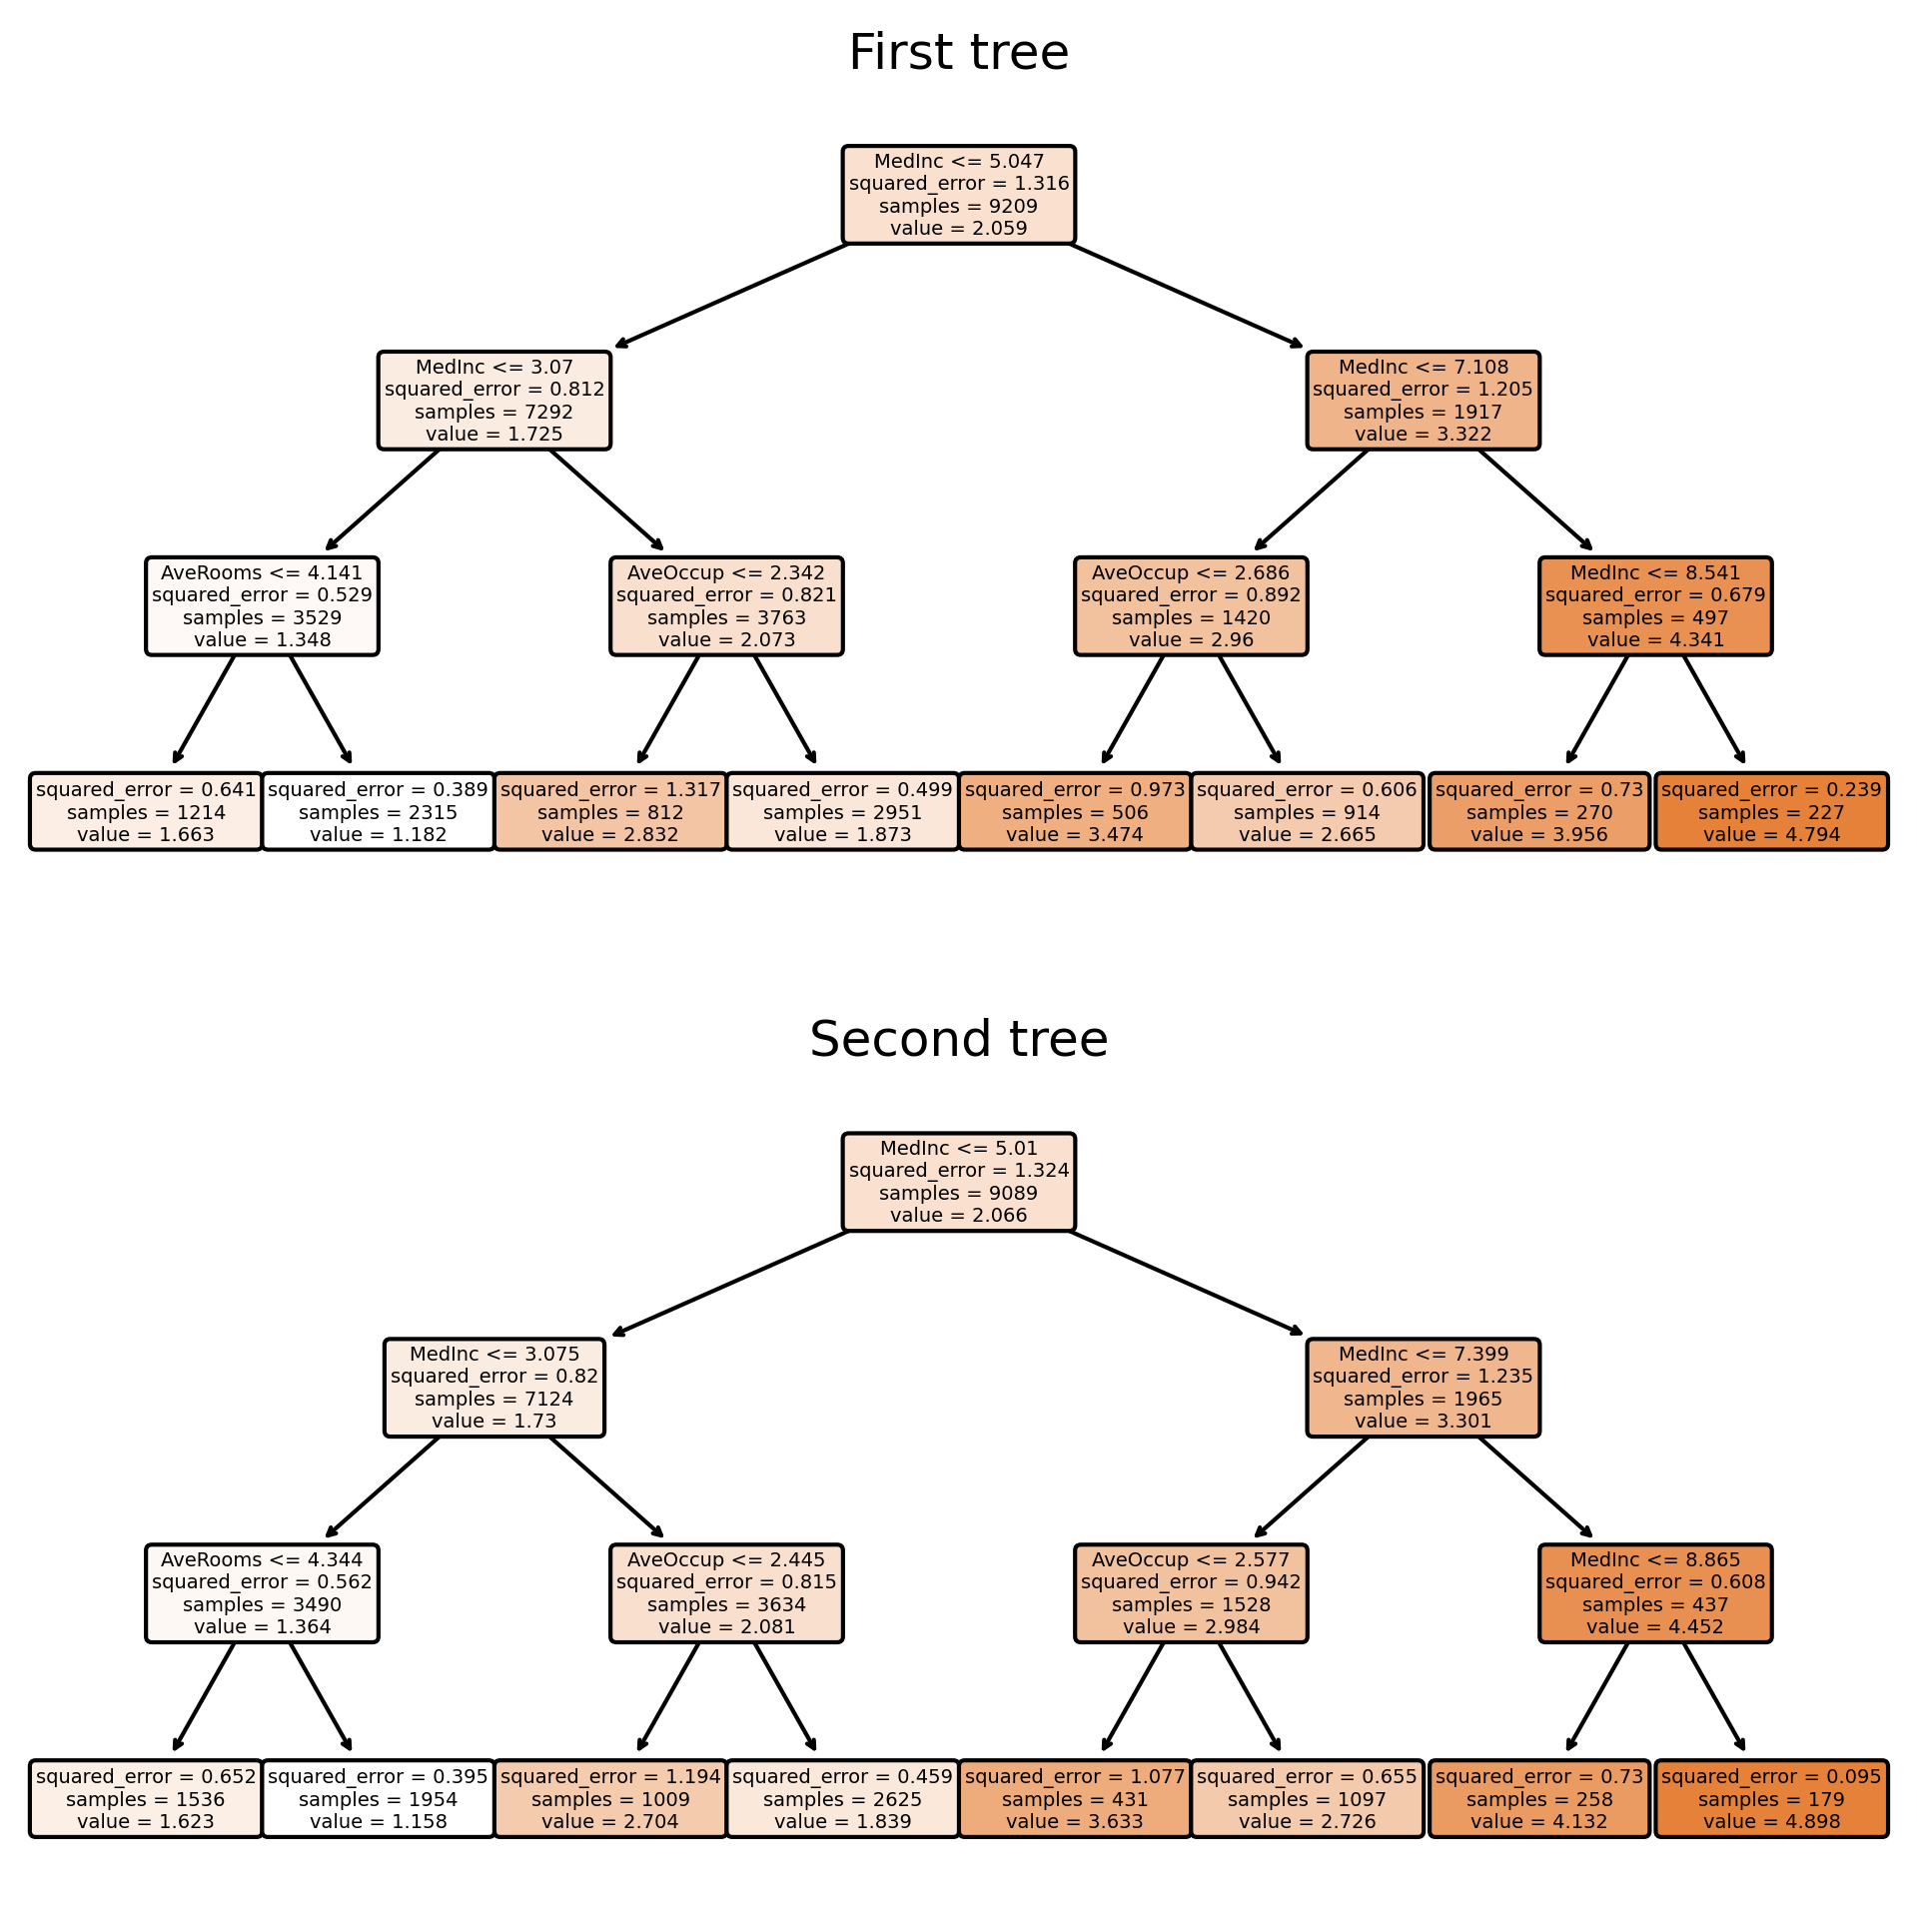

In [9]:
plt.figure(figsize=(8, 8), dpi=300)

# first tree
plt.subplot(2, 1, 1)
plot_tree(
    decision_tree=rf.estimators_[0],
    feature_names=X_train.columns.to_list(),
    filled=True,  # color the squares
    rounded=True  # round squares
)
plt.title("First tree")


# second tree
plt.subplot(2, 1, 2)
plot_tree(
    decision_tree=rf.estimators_[1],
    feature_names=X_train.columns.to_list(),
    filled=True,  # color the squares
    rounded=True  # round squares
)
plt.title("Second tree")

plt.show()

## Feature contribution

The idea is to take the average of the feature contribution in each tree.

In [10]:
# tree one

first_split = 1.725 - 2.059
second_split = 2.073 - 1.725
third_split = 1.873 - 2.073

MedianInc_t1 = first_split + second_split
AveOccup_t1 = third_split

MedianInc_t1, AveOccup_t1

(0.01399999999999979, -0.19999999999999996)

In [11]:
# tree two

first_split = 1.73 - 2.066
second_split = 2.081 - 1.73
third_split = 1.839 - 2.081

MedianInc_t2 = first_split + second_split
AveOccup_t2 = third_split

MedianInc_t2, AveOccup_t2

(0.015000000000000124, -0.242)

In [12]:
MedInc = (MedianInc_t1 + MedianInc_t2)/2
AveOccup = (AveOccup_t1 + AveOccup_t2)/2

MedInc, AveOccup

(0.014499999999999957, -0.22099999999999997)

In [13]:
# prediction, calculated manually

y_mean =  (2.059 + 2.066)/2

y_mean + MedInc + AveOccup

1.8559999999999999

In [14]:
# prediction of the random forests

rf.predict(X_test.loc[sample_id].to_frame().T)

array([1.85598569])

## Tree interpreter

In [15]:
from treeinterpreter import treeinterpreter as ti

In [16]:
prediction, bias, contributions = ti.predict(rf, X_test)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [17]:
y_mean

2.0625

In [18]:
bias

array([2.06228458, 2.06228458, 2.06228458, ..., 2.06228458, 2.06228458,
       2.06228458])

In [19]:
contributions[0]

array([ 0.01461676,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.22091565])

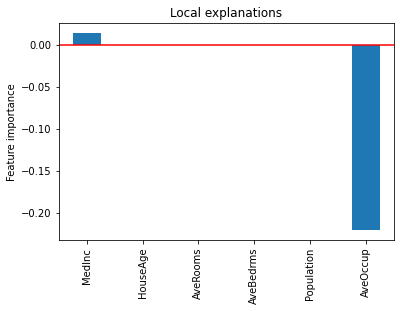

In [20]:
pd.Series(contributions[0], index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

In [21]:
prediction[0]

array([1.85598569])

In [22]:
X_test.reset_index(drop=True, inplace=True)

X_test.loc[0]

MedInc           4.151800
HouseAge        22.000000
AveRooms         5.663073
AveBedrms        1.075472
Population    1551.000000
AveOccup         4.180593
Name: 0, dtype: float64

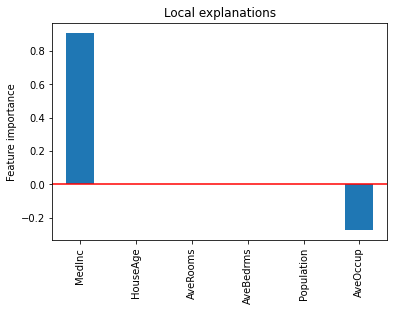

In [23]:
pd.Series(contributions[1], index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

In [24]:
prediction[1]

array([2.69550139])

In [25]:
X_test.reset_index(drop=True, inplace=True)

X_test.loc[1]

MedInc           5.779600
HouseAge        32.000000
AveRooms         6.107226
AveBedrms        0.927739
Population    1296.000000
AveOccup         3.020979
Name: 1, dtype: float64

Note that the decrease in price is not proportional to the AveOccup, because this is not a linear model.